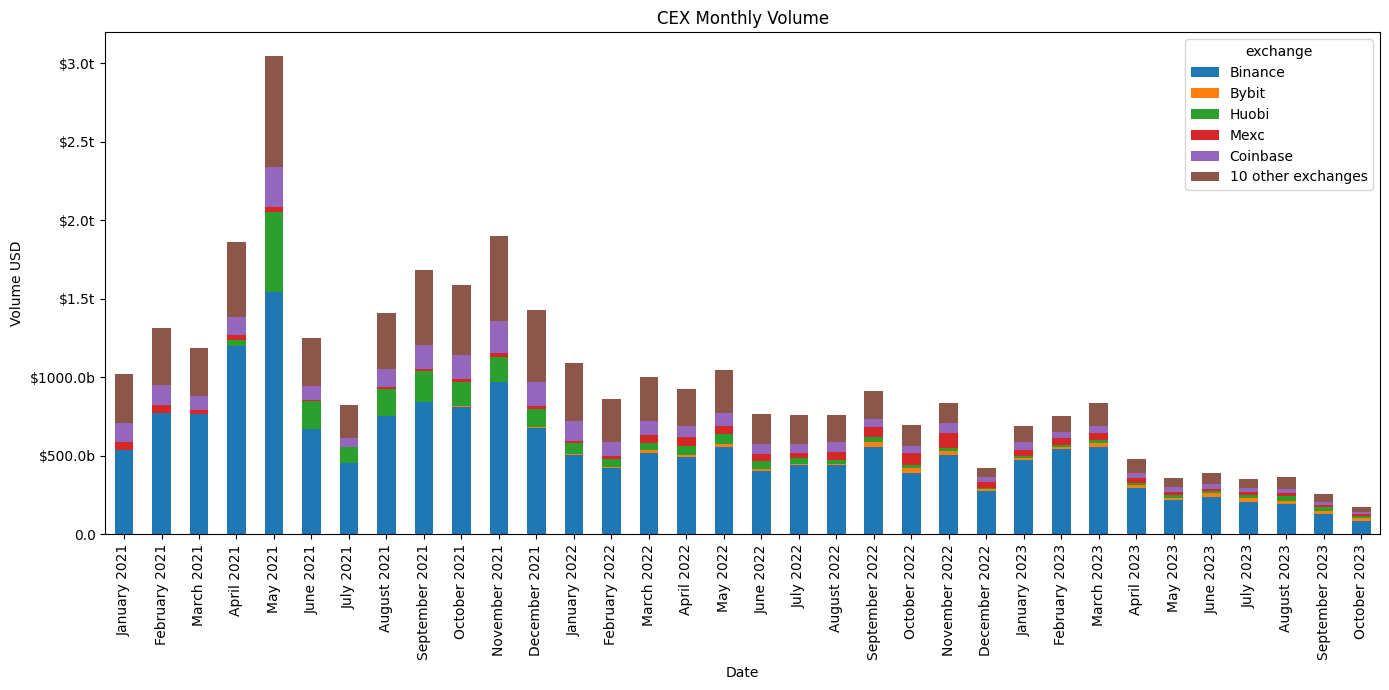

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

url = "https://web3api.io/api/v2/market/metrics/exchanges/volumes/historical?direction=desc&timeFormat=hr"

headers = {
    "accept": "application/json",
    "x-api-key": "API-KEY-HERE"
}

def get_volume_data(start_date, end_date):
    params = {
        "startDate": start_date.strftime("%Y-%m-%dT%H:%M:%S"),
        "endDate": end_date.strftime("%Y-%m-%dT%H:%M:%S")
    }
    response = requests.get(url, headers=headers, params=params)
    response_json = response.json()
    
    if 'payload' in response_json and 'data' in response_json['payload']:
        return response_json['payload']['data']
    else:
        print(f"Error getting data for date range {start_date} to {end_date}. Response: {response_json}")
        return []

start_date = datetime(2021, 1, 1)  # Starting from January 1, 2021
end_date = start_date + timedelta(days=30)
all_data = []

while end_date <= datetime.now():
    all_data.extend(get_volume_data(start_date, end_date))
    start_date = end_date
    end_date = start_date + timedelta(days=30)

df = pd.DataFrame(all_data)

df['exchange'] = df['exchange'].str.replace('gdax', 'coinbase').str.capitalize()

pivot_df = df.pivot(index='timestamp', columns='exchange', values='volumeUSD')
pivot_df.index = pd.to_datetime(pivot_df.index, format="%Y-%m-%d %H:%M:%S %f")

pivot_df = pivot_df.fillna(0)
for column in pivot_df.columns:
    pivot_df[column] = pd.to_numeric(pivot_df[column], errors='coerce')

pivot_df = pivot_df.resample('M').sum()

top_5_exchanges = pivot_df.iloc[-1].nlargest(5).index
other_exchanges = pivot_df.drop(columns=top_5_exchanges)

num_other_exchanges = other_exchanges.shape[1]
pivot_df[f'{num_other_exchanges} other exchanges'] = other_exchanges.sum(axis=1)
pivot_df = pivot_df[top_5_exchanges.tolist() + [f'{num_other_exchanges} other exchanges']]

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7))
ax.set_title('CEX Monthly Volume')
ax.set_xlabel('Date')
ax.set_ylabel('Volume USD')

def y_fmt(x, y):
    if x > 1e12:
        val = round(x / 1e12, 1)
        return '${}t'.format(val)
    elif x > 1e9:
        val = round(x / 1e9, 1)
        return '${}b'.format(val)
    else:
        return x

ax.yaxis.set_major_formatter(plt.FuncFormatter(y_fmt))
ax.set_xticklabels([x.strftime('%B %Y') for x in pivot_df.index])
plt.tight_layout()
plt.show()